In [1]:
from pathlib import Path
import csv
from itertools import groupby
import h5py
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import matplotlib
from matplotlib import pyplot as plt

# Configuration & Utilities

In [2]:
random.seed(42)
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
ANNOTATIONS_PATH = "/media/xtrem/data/experiments/nicolingua-0001-language-id/language-id-annotations/metadata.csv"
FEATURE_DIRS = [
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-z',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-z'
]

In [3]:
annotation_specification = {
    0: {
        'id': 0,
        'label': "maninka",
        'required_tags': set(['ct-speech', 'lng-maninka']),
        'forbidden_tags':  set(['lng-susu', 'lng-pular'])
    },
    1: {
        'id': 1,
        'label': "susu",
        'required_tags': set(['ct-speech', 'lng-susu']),
        'forbidden_tags':  set(['lng-maninka', 'lng-pular'])
    },
    2: {
        'id': 2,
        'label': "pular",
        'required_tags': set(['ct-speech', 'lng-pular']),
        'forbidden_tags':  set(['lng-susu', 'lng-maninka'])
    }
}

In [4]:
def to_user_friendly_feature_name(fv_name):
    name = fv_name \
        .replace("features-", "") \
        .replace("wav2vec_", "") \
        .replace("average", "avg") \
        .replace("timestep", "T") \
        .replace("c.", "Context") \
        .replace("z.", "Latent")
    return name

# Load annotations

In [5]:
def load_annotations(a_file_path, a_specification):
    with open(ANNOTATIONS_PATH) as f:
        reader = csv.DictReader(f)
        for row in reader:
            tag_set = set([t.strip() for t in row['tags'].split(";")])
            for label in annotation_specification.keys():
                spec = annotation_specification[label]
                if spec['required_tags'].issubset(tag_set):
                    if spec['forbidden_tags'].isdisjoint(tag_set):
                        yield row['file'], label
                        break

data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
random.shuffle(data)
audio_files, audio_labels = zip(*data)

## Inspect label counts

In [6]:
def inspect_label_counts():
    for label in annotation_specification:
        count = len([l for l in audio_labels if l == label])
        print("{:10} ({}): {}".format(
            annotation_specification[label]['label'],
            label, 
            count
        ))
inspect_label_counts()

maninka    (0): 114
susu       (1): 32
pular      (2): 28


## Balance data

In [7]:
count_per_class = 28
data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
balanced_data = []
for label in annotation_specification:
    balanced_data.extend([d for d in data if d[1] == label][:count_per_class])
random.shuffle(balanced_data)
audio_files, audio_labels = zip(*balanced_data)

In [8]:
inspect_label_counts()

maninka    (0): 28
susu       (1): 28
pular      (2): 28


# Load features

In [9]:
def load_features(audio_files, features_input_dir):
    id_list = []
    features_list = []

    for audio_file_name in audio_files:
        feature_file_name = audio_file_name.replace(".wav", ".h5context")
        feature_path = Path(features_input_dir) / feature_file_name
        with h5py.File(feature_path, 'r') as f:
            features_shape = f['info'][1:].astype(int)
            features = np.array(f['features'][:]).reshape(features_shape)
            # features = pool_feature_last_seq(features)
            features_list.append(features)
    return features_list

In [10]:
raw_features = {}
for feature_dir in FEATURE_DIRS:
    feature_name = Path(feature_dir).stem
    raw_features[feature_name] = load_features(audio_files, feature_dir)

## Inspect feature shapes

In [11]:
for feature_name in raw_features.keys():
    print("feature_name: {}. feature shape: {}".format(
        to_user_friendly_feature_name(feature_name),
        raw_features['wav2vec_features-c'][0].shape
    ))

feature_name: c. feature shape: (2998, 512)
feature_name: z. feature shape: (2998, 512)
feature_name: retrained-c. feature shape: (2998, 512)
feature_name: retrained-z. feature shape: (2998, 512)


## Extract feature vectors

In [12]:
def extract_last_timestep_features(raw_features):
    return raw_features[-1, :]

def extract_neuron_average_features(raw_features):
    return np.mean(raw_features, axis=0)

feature_extractors = {
    'last_timestep': extract_last_timestep_features,
    'neuron_average': extract_neuron_average_features
}

In [13]:
feature_vectors = {}
for feature_name in raw_features.keys():
    for feature_extractor_name in feature_extractors.keys():
        fv_name = f"{feature_name}__{feature_extractor_name}"
        feature_vectors[fv_name] = []
        for f in raw_features[feature_name]:
            feature_vectors[fv_name].append(
                feature_extractors[feature_extractor_name](f)
            )
            
        feature_vectors[fv_name] = np.array(feature_vectors[fv_name])

## Inspect feature vectors

In [14]:
for fvname in feature_vectors.keys():
    print(fvname, feature_vectors[fvname][0].shape)

wav2vec_features-c__last_timestep (512,)
wav2vec_features-c__neuron_average (512,)
wav2vec_features-z__last_timestep (512,)
wav2vec_features-z__neuron_average (512,)
retrained-wav2vec_features-c__last_timestep (512,)
retrained-wav2vec_features-c__neuron_average (512,)
retrained-wav2vec_features-z__last_timestep (512,)
retrained-wav2vec_features-z__neuron_average (512,)


# Cluster feature vectors

In [15]:
for fv_name in feature_vectors.keys():
    X = feature_vectors[fv_name]
    kmeans = KMeans(n_clusters=3).fit(X)
    score = sklearn.metrics.normalized_mutual_info_score(audio_labels, kmeans.labels_)
    print(fv_name, score)
    

wav2vec_features-c__last_timestep 0.049179917954828234
wav2vec_features-c__neuron_average 0.12393447756237014
wav2vec_features-z__last_timestep 0.03605841311703659
wav2vec_features-z__neuron_average 0.0771762508912816
retrained-wav2vec_features-c__last_timestep 0.01452730717644869
retrained-wav2vec_features-c__neuron_average 0.023935390806815306
retrained-wav2vec_features-z__last_timestep 0.007317248202893126
retrained-wav2vec_features-z__neuron_average 0.025154231742564728


In [16]:
def get_sample_weights(y):
    count_per_class = {k: len(list(g)) for k, g in groupby(sorted(y))}
    class_count = len(count_per_class)
    weight_per_class = {k: 1/class_count/c for k, c in count_per_class.items()}
    return [weight_per_class[yi] for yi in y]

wav2vec_features-c__last_timestep 0.9743589743589743 0.26764346764346764
plt.subplot(2, 4, 1)
wav2vec_features-c__neuron_average 0.826007326007326 0.5815628815628815
plt.subplot(2, 4, 2)
wav2vec_features-z__last_timestep 1.0 0.3448107448107448
plt.subplot(2, 4, 3)
wav2vec_features-z__neuron_average 0.8278388278388278 0.46227106227106224
plt.subplot(2, 4, 4)
retrained-wav2vec_features-c__last_timestep 0.9042735042735042 0.3814407814407814
plt.subplot(2, 4, 5)
retrained-wav2vec_features-c__neuron_average 0.9743589743589743 0.6532356532356532
plt.subplot(2, 4, 6)
retrained-wav2vec_features-z__last_timestep 0.9743589743589743 0.34798534798534797
plt.subplot(2, 4, 7)
retrained-wav2vec_features-z__neuron_average 0.9267399267399268 0.4638583638583638
plt.subplot(2, 4, 8)
0.9267399267399268 0.4638583638583638


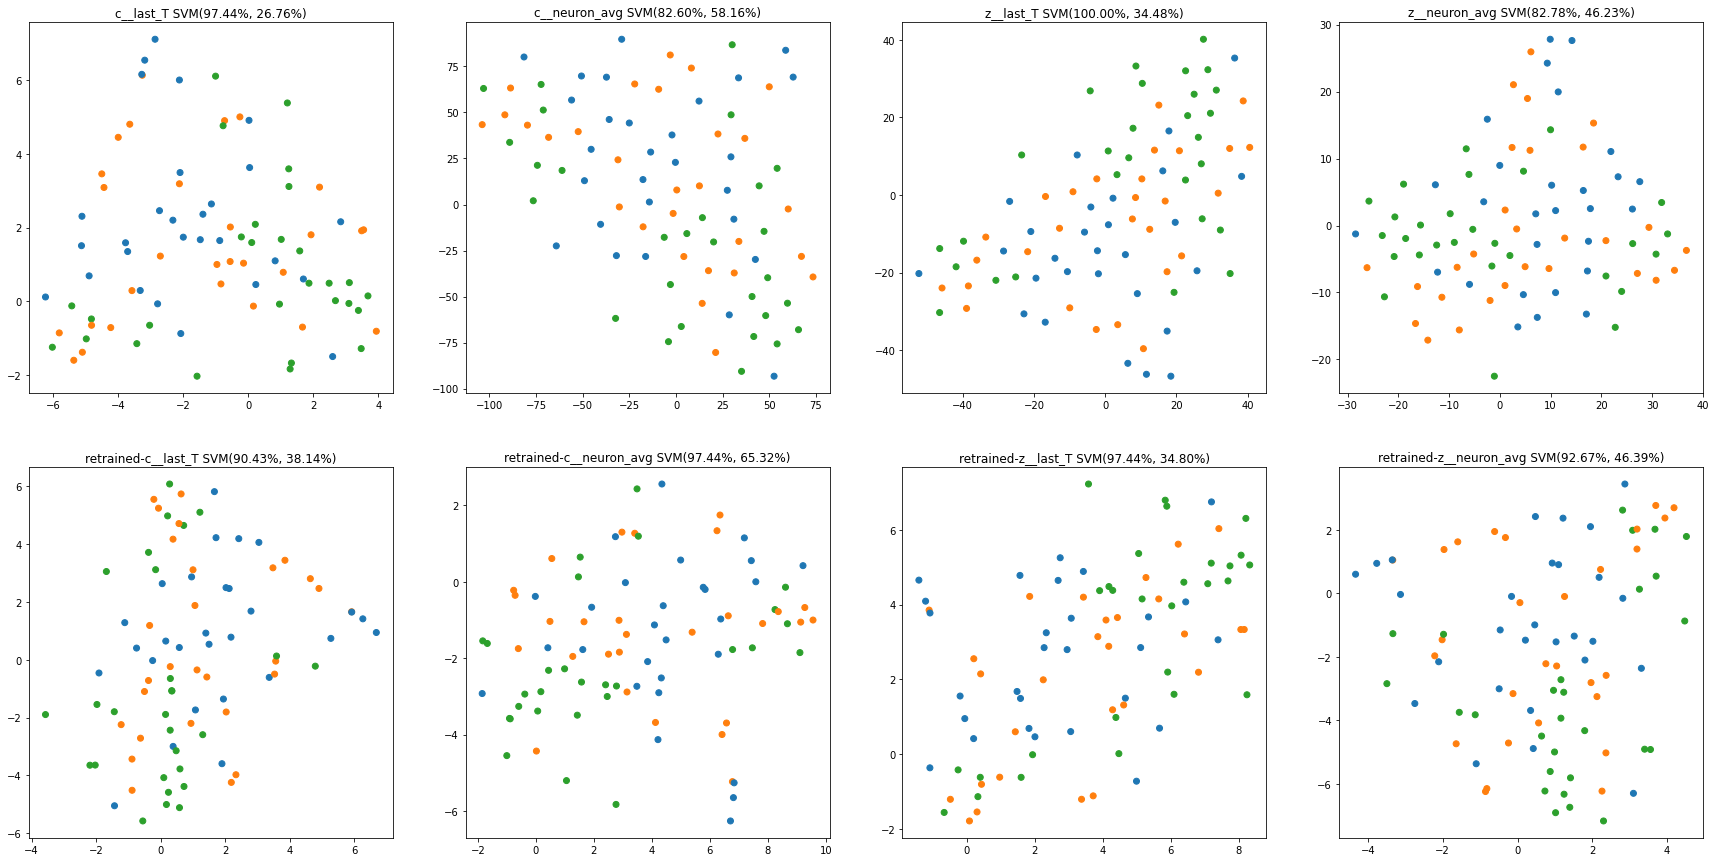

In [17]:
train_size = len(audio_labels) // 2

plt.figure(figsize=(30, 15))

for index, fv_name in enumerate(feature_vectors.keys()):
    X = feature_vectors[fv_name]
    
    x_train = X[:train_size]
    y_train = audio_labels[:train_size]

    x_test = X[train_size:]
    y_test = audio_labels[train_size:]

    svc = SVC(kernel="poly")
    svc.fit(x_train, y_train)

    train_acc = svc.score(x_train, y_train, sample_weight=get_sample_weights(y_train))
    test_acc = svc.score(x_test, y_test, sample_weight=get_sample_weights(y_test))
    print(fv_name, train_acc, test_acc)
    
    print(f'plt.subplot({2}, {int(np.ceil(len(feature_vectors.keys())/2))}, {index+1})')
    plt.subplot(2, int(np.ceil(len(feature_vectors.keys())/2)), index+1)
    
    projected_x = TSNE(n_components=2).fit_transform(feature_vectors['retrained-wav2vec_features-c__neuron_average'])
    plt.scatter(projected_x[:, 0], projected_x[:, 1], c=[COLORS[l] for l in audio_labels])
    title = to_user_friendly_feature_name(fv_name)
    
    title = f"{title} SVM({train_acc:.02%}, {test_acc:.02%})"
    
    plt.title(title)


print(train_acc, test_acc)